<img align="right" width="400" src="https://www.fhnw.ch/de/++theme++web16theme/assets/media/img/fachhochschule-nordwestschweiz-fhnw-logo.svg" alt="FHNW Logo">


# Transformers Fine Tuning

by Fabian Märki

## Summary
The aim of this notebook is to show how to further fine tune a pretrained model for sequence classification (the model has been fine tuned for a similar task already). In a first round, only the newly added classification head is trained (all other layers are frozen - the idea is to adjust the class vectors of the classification head to the pretrained feature extractor). In a second round, the complete model is trained (by unfreezing all layers).   


## Links
- [Fine-tune a pretrained model](https://huggingface.co/docs/transformers/training)
- [Course](https://huggingface.co/course/chapter1) on how to use Huggingface's transformer models (from simple using pipelines to complex implementing the training loop).
- [Notebooks](https://huggingface.co/docs/transformers/notebooks) on a different topics (fine tuning,  translation, summarization, question answering, audio classification, image classification etc.)


<a href="https://colab.research.google.com/github/markif/2023_HS_DAS_NLP_Notebooks/blob/master/08_b_Transformers_Text_Classifier_FineTuning_a_FineTunde_Model_in_2_Steps.ipynb">
  <img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [1]:
%%capture

!pip install 'fhnw-nlp-utils>=0.8.0,<0.9.0'

from fhnw.nlp.utils.storage import load_dataframe
from fhnw.nlp.utils.storage import download
from fhnw.nlp.utils.system import set_log_level

import pandas as pd
import numpy as np

set_log_level()
import tensorflow as tf

**Make sure that a GPU is available (see [here](https://www.tutorialspoint.com/google_colab/google_colab_using_free_gpu.htm))!!!**

In [2]:
from fhnw.nlp.utils.system import system_info
print(system_info())

OS name: posix
Platform name: Linux
Platform release: 6.2.0-32-generic
Python version: 3.8.10
CPU cores: 6
RAM: 31.1GB total and 25.43GB available
Tensorflow version: 2.12.0
GPU is available
GPU is a NVIDIA GeForce RTX 2070 with Max-Q Design with 8192MiB


In [3]:
%%time
download("https://drive.switch.ch/index.php/s/0hE8wO4FbfGIJld/download", "data/german_doctor_reviews_tokenized.parq")
data = load_dataframe("data/german_doctor_reviews_tokenized.parq")

CPU times: user 6.58 s, sys: 1.54 s, total: 8.12 s
Wall time: 4.9 s


In [4]:
# remove all neutral sentimens
data = data.loc[(data["label"] != "neutral")]
data.shape

(331187, 10)

In [5]:
data.head(3)

,text_original,rating,text,label,sentiment,token_clean,text_clean,token_lemma,token_stem,token_clean_stopwords
0,Ich bin franzose und bin seit ein paar Wochen ...,2.0,Ich bin franzose und bin seit ein paar Wochen ...,positive,1,"[ich, bin, franzose, und, bin, seit, ein, paar...",ich bin franzose und bin seit ein paar wochen ...,"[franzose, seit, paar, wochen, muenchen, zahn,...","[franzos, seit, paar, woch, muench, ., zahn, s...","[franzose, seit, paar, wochen, muenchen, ., za..."
1,Dieser Arzt ist das unmöglichste was mir in me...,6.0,Dieser Arzt ist das unmöglichste was mir in me...,negative,-1,"[dieser, arzt, ist, das, unmöglichste, was, mi...",dieser arzt ist das unmöglichste was mir in me...,"[arzt, unmöglichste, leben, je, begegnen, unfr...","[arzt, unmog, leb, je, begegnet, unfreund, ,, ...","[arzt, unmöglichste, leben, je, begegnet, unfr..."
2,Hatte akute Beschwerden am Rücken. Herr Magura...,1.0,Hatte akute Beschwerden am Rücken. Herr Magura...,positive,1,"[hatte, akute, beschwerden, am, rücken, ., her...",hatte akute beschwerden am rücken . herr magur...,"[akut, beschwerden, rücken, magura, erste, arz...","[akut, beschwerd, ruck, ., magura, erst, arzt,...","[akute, beschwerden, rücken, ., magura, erste,..."


In [6]:
%%capture

!pip install torch
!pip install transformers
!pip install datasets
!pip install evaluate
!pip install accelerate

In [7]:
from fhnw.nlp.utils.transformers import dataframe_to_dataset
from fhnw.nlp.utils.transformers import dataframe_to_datasets
from fhnw.nlp.utils.transformers import get_compute_device

In [8]:
params = {
    "verbose": True,
    "shuffle": True,
    "n_samples": len(data),
    # modify batch_size in case you experience memory issues
    "batch_size": 8,
    "X_column_name": "text",
    "y_column_name": "label",
    "y_column_name_prediction": "prediction",
    "compute_device": get_compute_device(),
    # see https://huggingface.co/philschmid/distilbert-base-multilingual-cased-sentiment-2/tree/main
    "transformers_model_name": "philschmid/distilbert-base-multilingual-cased-sentiment-2",
    "transformers_model_version": "83ff874", #can be the name of a branch or a commit hash
}

In [9]:
datasets = dataframe_to_datasets(params, data)

Inferred classification type: binary
264949 train examples
66238 test examples
211959 train examples
52990 test examples


Changing max_length (to e.g. `input_sequence_length` or even smaller) can greatly speedup training and can even help to converge training.

In [10]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(params["transformers_model_name"])

def tokenize_function(examples):
    X_column_name = params.get("X_column_name", "text")
    input_sequence_length = params.get("input_sequence_length", 256)
    
    return tokenizer(
        examples[X_column_name], 
        #padding=True,
        #max_length=input_sequence_length,
        padding="max_length",
        truncation=True,
    )

tokenized_datasets = datasets.map(tokenize_function, batched=True)

Map:   0%|          | 0/211959 [00:00<?, ? examples/s]

Map:   0%|          | 0/52990 [00:00<?, ? examples/s]

Map:   0%|          | 0/66238 [00:00<?, ? examples/s]

In [11]:
%%time

print("Text: ", tokenizer.convert_ids_to_tokens(tokenized_datasets["test"]["input_ids"][0])[0:30])
print("IDs: ", tokenized_datasets["test"]["input_ids"][0][0:30])

Text:  ['[CLS]', 'die', 'pra', '##xis', 'und', 'dr', '.', 'ander', '##ya', 'sind', 'sehr', 'zu', 'em', '##pf', '##eh', '##len', 'f', '##ühl', '##te', 'mich', 'er', '##nst', '##genommen', 'und', 'sehr', 'gut', 'auf', '##gehoben', 'die', 'op']
IDs:  [101, 10128, 69857, 53496, 10130, 17094, 119, 23336, 10679, 10762, 14483, 10304, 10266, 55942, 25723, 11608, 174, 48288, 10216, 52866, 10163, 40300, 29789, 10130, 14483, 23639, 10329, 77630, 10128, 10303]
CPU times: user 22.9 s, sys: 299 ms, total: 23.2 s
Wall time: 23.1 s


In [12]:
train_dataset = tokenized_datasets["train"].shuffle(seed=42)
eval_dataset = tokenized_datasets["test"]
#train_dataset = tokenized_datasets["train"].shuffle(seed=42).select(range(1000))
#eval_dataset = tokenized_datasets["test"].select(range(1000))

In [13]:
from transformers import AutoModelForSequenceClassification

computed_objects_column_name = params.get("computed_objects_column_name", "computed_objects")
label_binarizer = params[computed_objects_column_name]["label_binarizer"]
num_classes = len(label_binarizer.classes_)

model = AutoModelForSequenceClassification.from_pretrained(params["transformers_model_name"])

Print the model config to see the labels of the model.

See also [here](https://github.com/huggingface/transformers/issues/5905) and [here](https://github.com/huggingface/transformers/blob/6e8a38568eb874f31eb49c42285c3a634fca12e7/examples/token-classification/run_ner.py#L146)

In [14]:
config = model.config

config

DistilBertConfig {
  "_name_or_path": "philschmid/distilbert-base-multilingual-cased-sentiment-2",
  "activation": "gelu",
  "architectures": [
    "DistilBertForSequenceClassification"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "negative",
    "1": "neutral",
    "2": "positive"
  },
  "initializer_range": 0.02,
  "label2id": {
    "negative": "0",
    "neutral": "1",
    "positive": "2"
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "output_past": true,
  "pad_token_id": 0,
  "problem_type": "single_label_classification",
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "torch_dtype": "float32",
  "transformers_version": "4.29.1",
  "vocab_size": 119547
}

Setup the new labels and adjust the model config.

In [16]:
label_map = {i: label for i, label in enumerate(label_binarizer.classes_)}

label_map

{0: 'negative', 1: 'positive'}

In [17]:
config.num_labels = num_classes
config.id2label = label_map
config.label2id = {label: i for i, label in enumerate(label_binarizer.classes_)}

config

DistilBertConfig {
  "_name_or_path": "philschmid/distilbert-base-multilingual-cased-sentiment-2",
  "activation": "gelu",
  "architectures": [
    "DistilBertForSequenceClassification"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "negative",
    "1": "positive"
  },
  "initializer_range": 0.02,
  "label2id": {
    "negative": 0,
    "positive": 1
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "output_past": true,
  "pad_token_id": 0,
  "problem_type": "single_label_classification",
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "torch_dtype": "float32",
  "transformers_version": "4.29.1",
  "vocab_size": 119547
}

Reinitiallize the classification layer to match the number of the new labels (and do not forget to adjust the model's <code>num_labels</code>.

In [18]:
import torch

model.classifier = torch.nn.Linear(in_features=model.classifier.in_features, out_features=config.num_labels, bias=True)
model.config = config
model.num_labels = config.num_labels

Check which layers are trained.

In [19]:
for name, param in model.named_parameters():
     print(name, param.requires_grad)

distilbert.embeddings.word_embeddings.weight True
distilbert.embeddings.position_embeddings.weight True
distilbert.embeddings.LayerNorm.weight True
distilbert.embeddings.LayerNorm.bias True
distilbert.transformer.layer.0.attention.q_lin.weight True
distilbert.transformer.layer.0.attention.q_lin.bias True
distilbert.transformer.layer.0.attention.k_lin.weight True
distilbert.transformer.layer.0.attention.k_lin.bias True
distilbert.transformer.layer.0.attention.v_lin.weight True
distilbert.transformer.layer.0.attention.v_lin.bias True
distilbert.transformer.layer.0.attention.out_lin.weight True
distilbert.transformer.layer.0.attention.out_lin.bias True
distilbert.transformer.layer.0.sa_layer_norm.weight True
distilbert.transformer.layer.0.sa_layer_norm.bias True
distilbert.transformer.layer.0.ffn.lin1.weight True
distilbert.transformer.layer.0.ffn.lin1.bias True
distilbert.transformer.layer.0.ffn.lin2.weight True
distilbert.transformer.layer.0.ffn.lin2.bias True
distilbert.transformer.lay

Freeze all weights/biases for training and only allow the classification layer to be trained.

In [20]:
# freeze weights/bias for training (only train classifier)

for name, param in model.named_parameters():
     if "classifier" not in name: 
        param.requires_grad = False

Double check

In [21]:
for name, param in model.named_parameters():
     print(name, param.requires_grad)

distilbert.embeddings.word_embeddings.weight False
distilbert.embeddings.position_embeddings.weight False
distilbert.embeddings.LayerNorm.weight False
distilbert.embeddings.LayerNorm.bias False
distilbert.transformer.layer.0.attention.q_lin.weight False
distilbert.transformer.layer.0.attention.q_lin.bias False
distilbert.transformer.layer.0.attention.k_lin.weight False
distilbert.transformer.layer.0.attention.k_lin.bias False
distilbert.transformer.layer.0.attention.v_lin.weight False
distilbert.transformer.layer.0.attention.v_lin.bias False
distilbert.transformer.layer.0.attention.out_lin.weight False
distilbert.transformer.layer.0.attention.out_lin.bias False
distilbert.transformer.layer.0.sa_layer_norm.weight False
distilbert.transformer.layer.0.sa_layer_norm.bias False
distilbert.transformer.layer.0.ffn.lin1.weight False
distilbert.transformer.layer.0.ffn.lin1.bias False
distilbert.transformer.layer.0.ffn.lin2.weight False
distilbert.transformer.layer.0.ffn.lin2.bias False
distilbe

In [22]:
import numpy as np
import evaluate

#metric = evaluate.load("accuracy")
metric = evaluate.combine(["accuracy", "recall", "precision", "f1"])

In [23]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

In [24]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    num_train_epochs = params.get("training_epochs", 3),
    report_to = "none",
    output_dir = "test_trainer", 
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    save_total_limit = 1,
    #evaluation_strategy ="steps",
    #save_strategy = "steps",
    #eval_steps = 100, # Evaluation and Save happens every 100 steps 
    #save_total_limit = 3, # Only last 3 models are saved. Older ones are deleted.
    load_best_model_at_end = True,
    auto_find_batch_size = True,
    #per_device_train_batch_size = params.get("batch_size", 4),  # batch size per device during training
    #per_device_eval_batch_size = params.get("batch_size", 4), # batch size for evaluation
)

In [25]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    compute_metrics=compute_metrics,
)

In [29]:
%%time

train_result = trainer.train()

/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,Recall,Precision,F1
1,0.150100,0.146904,0.943175,0.973690,0.963575,0.968606
2,0.138700,0.145400,0.943582,0.975249,0.962578,0.968872
3,0.150400,0.145764,0.943326,0.975048,0.962491,0.968729


CPU times: user 3h 18min 32s, sys: 25.1 s, total: 3h 18min 57s
Wall time: 3h 18min 47s


It seems one training epoch would have been enough.

Let's store all this work fist.

In [30]:
model_path = "data/"+params["transformers_model_name"]+"-sentiment-classifier"

model.save_pretrained(model_path)
_ = tokenizer.save_pretrained(model_path)

Remark: I experienced an OOM during startup of the second finetuning step. In this case you need to restart and reload the model (see commented code below).

In [ ]:
# model_path = "data/"+params["transformers_model_name"]+"-sentiment-classifier"

#tokenizer = AutoTokenizer.from_pretrained(model_path, local_files_only=True)
#model = AutoModelForSequenceClassification.from_pretrained(model_path, local_files_only=True)

Unfreeze all layers to allow for a full model training.

In [27]:
for name, param in model.named_parameters():
        param.requires_grad = True

Setup trainer again (initialize with fresh parameters).

In [28]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    compute_metrics=compute_metrics,
)

In [29]:
%%time

train_result = trainer.train()

/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,Recall,Precision,F1
1,0.113200,0.132427,0.972221,0.990928,0.978491,0.984670
2,0.079500,0.099173,0.975830,0.989318,0.983923,0.986613
3,0.092000,0.099803,0.977264,0.990073,0.984755,0.987407


CPU times: user 7h 48min 27s, sys: 26.1 s, total: 7h 48min 53s
Wall time: 7h 48min 49s


In [30]:
model_path = "data/"+params["transformers_model_name"]+"-sentiment-full"

model.save_pretrained(model_path)
_ = tokenizer.save_pretrained(model_path)

Let's put this into a Pipeline (see also [here](https://huggingface.co/docs/transformers/add_new_pipeline))

In [31]:
from transformers import Pipeline

class DoctorReviewsSentimentPipeline(Pipeline):
    
    def _sanitize_parameters(self, **kwargs):
        preprocess_kwargs = {}
        if "input_sequence_length" in kwargs:
            preprocess_kwargs["input_sequence_length"] = kwargs["input_sequence_length"]
        return preprocess_kwargs, {}, {}

    def preprocess(self, text, input_sequence_length=256):
        # max_length can have a major performance impact (choose it wisely).
        # if there are occasional very long sentence compared to the others, 
        # the whole batch will need to be 256 tokens long (i.e. [batch_size, 256]),
        # leading to a slowdown (on bigger batches the program might even crash).
        #
        # So it could make sense to choose a shorter input_sequence_length
        # (however, there is a tradeoff between model performance vs. compute performance)
        return self.tokenizer(text, 
                              padding=True, 
                              truncation=True, 
                              max_length=input_sequence_length, 
                              return_tensors=self.framework)

    def _forward(self, model_inputs):
        return self.model(**model_inputs)

    def postprocess(self, model_outputs):
        import torch
        import numpy as np 
        
        predictions = np.argmax(model_outputs.logits, axis=-1)

        if len(predictions) > 1:
            return ["positive" if pred == 1 else "negative" for (idx,pred) in enumerate(predictions)]
        else:
            return "positive" if predictions[0] == 1 else "negative"

In [32]:
from transformers.pipelines import PIPELINE_REGISTRY
from transformers import AutoModelForSequenceClassification
from transformers import TFAutoModelForSequenceClassification

PIPELINE_REGISTRY.register_pipeline(
    "doctor-reviews-sentiment",
    pipeline_class=DoctorReviewsSentimentPipeline,
    pt_model=AutoModelForSequenceClassification,
    tf_model=TFAutoModelForSequenceClassification,
    #default={"pt": (model_name, model_version)},
    type="text",
)

In [33]:
from transformers import pipeline

sentiment_pipeline = pipeline("doctor-reviews-sentiment", 
                              model = model_path,
                              device = params.get("compute_device", "cpu"),
                              input_sequence_length = params.get("input_sequence_length", 256)
                             )

In [34]:
sentiment_pipeline(data[params["X_column_name"]].head(3).tolist())

['positive', 'negative', 'positive']

In [35]:
from transformers.pipelines.pt_utils import KeyDataset

batch_size = params.get("batch_size", 16)

dataset_test = datasets["test"]
dataset_val = datasets["validation"]
dataset_train = datasets["train"]

pred_iter_test = sentiment_pipeline(KeyDataset(dataset_test, params["X_column_name"]), batch_size=batch_size)
pred_iter_val = sentiment_pipeline(KeyDataset(dataset_val, params["X_column_name"]), batch_size=batch_size)
pred_iter_train = sentiment_pipeline(KeyDataset(dataset_train, params["X_column_name"]), batch_size=batch_size)

In [36]:
%%time 

# evaluate PipelineIterator
preds_test = [x for x in pred_iter_test]
preds_val = [x for x in pred_iter_val]
preds_train = [x for x in pred_iter_train]

CPU times: user 26min 10s, sys: 152 ms, total: 26min 10s
Wall time: 26min 10s


In [37]:
labels_test = ["positive" if label == 1 else "negative" for label in dataset_test["label"]]
labels_val = ["positive" if label == 1 else "negative" for label in dataset_val["label"]]
labels_train = ["positive" if label == 1 else "negative" for label in dataset_train["label"]]

Set Population: 331187
Accuracy: 0.9789


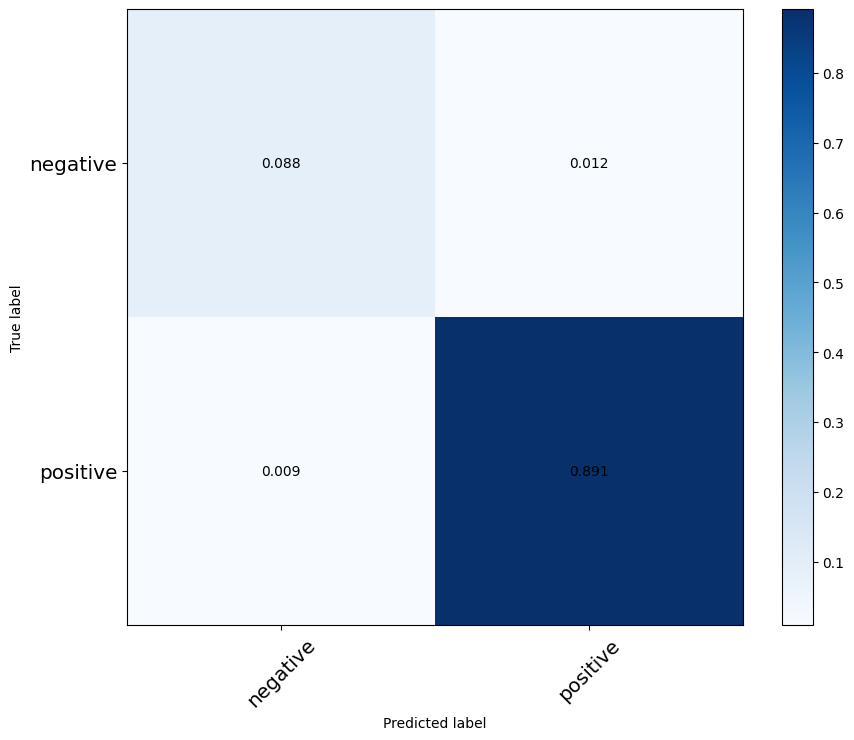

              precision    recall  f1-score   support

    negative       0.91      0.88      0.89     33022
    positive       0.99      0.99      0.99    298165

    accuracy                           0.98    331187
   macro avg       0.95      0.93      0.94    331187
weighted avg       0.98      0.98      0.98    331187



In [38]:
from fhnw.nlp.utils.ploting import report_classification_results

report_classification_results(params, labels_test + labels_val + labels_train, preds_test + preds_val + preds_train)

Set Population: 66238
Accuracy: 0.9747


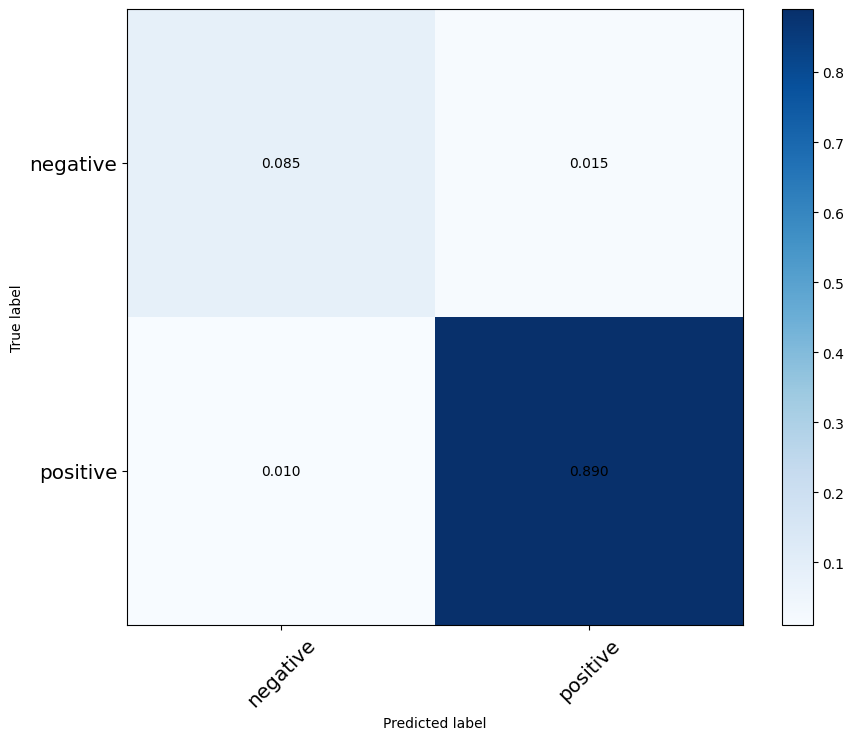

              precision    recall  f1-score   support

    negative       0.89      0.85      0.87      6604
    positive       0.98      0.99      0.99     59634

    accuracy                           0.97     66238
   macro avg       0.94      0.92      0.93     66238
weighted avg       0.97      0.97      0.97     66238



In [39]:
report_classification_results(params, labels_test, preds_test)

Still not as good as the CNN/RNN but better than the original model and the fine tuned model without adjusting the class vectors in the first step.<br>
A downside is certainly the tremendous amount of training time that was needed to fine tune the model. On the other hand the base model on a tremendous amount of data and knows a lot about language and thus the fine tuned model is very likely to generalize.